In [16]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import price_data as price
import statistics
import time
from datetime import date
import os
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport

# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(url="https://saturn.hasura.app/v1/graphql", headers={'x-hasura-admin-secret': 'Rc07SJt4ryC6RyNXDKFRAtFmRkGBbT8Ez3SdaEYsHQoHemCldvs52Kc803oK8X62'})

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

async def get_stored_data(symbol,timeframe):
    # Provide a GraphQL query
    split_symbol=symbol.split('/')
    base_currency=split_symbol[0]
    quote_currency=split_symbol[1]
    table=base_currency+quote_currency+'_'+timeframe
    if table=='BTCUSD_1d':
        query = gql(
            """
            query MyQuery {
                BTCUSD_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    elif table=='ETHUSD_1d':
        query = gql(
            """
            query MyQuery {
                ETHUSD_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    elif table=='ETHBTC_1d':
        query = gql(
            """
            query MyQuery {
                ETHBTC_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    else:
        return 'no such table'

    # Execute the query on the transport
    result = await client.execute_async(query)
    candles=result[table]
    df=pd.DataFrame({},columns=['unix','close','high','low','open'])
    for candle in candles:
        df=df.append(candle,ignore_index=True)

    return df.sort_values(by=['unix'], ignore_index=True)

    return result

def find_start(timestamps):
    start_found=False
    timestamps=list(map(lambda x:x[0]/1000,timestamps))
    index=len(timestamps)-1
    while not(start_found):
        print(timestamps[index])
        day=date.fromtimestamp(timestamps[index]).weekday()
        if day==0:
            start_found=True
        else:   
            index=index-1
    return index

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    timestamps=raw['unix']
    for i in range(len(timestamps)):
        if np.log10(timestamps.iloc[i])<12:
            raw.loc[i,'unix']=timestamps[i]*1000
    return raw.sort_values(by=['unix'], ignore_index=True)

month_dictionary={
    'Jan':1,
    'Feb':2,
    'Mar':3,
    'Apr':4,
    'May':5,
    'Jun':6,
    'Jul':7,
    'Aug':8,
    'Sep':9,
    'Oct':10,
    'Nov':11,
    'Dec':12,
}

def parse_data(datestring):
    string=datestring.split('-')
    month=month_dictionary[string[0]]
    day=int(string[1])
    year=int(string[2])
    d=date(year,month,day)

    return time.mktime(d.timetuple())

def process_coincodex_csv(filename):

    raw_data=pd.read_csv('data/'+filename)
    vectorised_parsing=np.vectorize(parse_data)
    timestamps=vectorised_parsing(raw_data['Date'].values)
    df=raw_data
    df['unix']=np.array(timestamps,np.int64)*1000
    df.columns = ['date','open','high','low','close','volume','market cap','unix']
    df.sort_values(by='unix', ignore_index=True, inplace=True)
    df.to_csv('data/Updated_'+filename)

    return df

btc_price_data= await get_stored_data('BTC/USD','1d')
btc_price_data

,unix,close,high,low,open
0,1.281802e+12,0.065500,0.065500,0.065500,0.065500
1,1.281888e+12,0.070000,0.070000,0.070000,0.070000
2,1.281974e+12,0.068000,0.068000,0.068000,0.068000
3,1.282061e+12,0.066700,0.066700,0.066700,0.066700
4,1.282147e+12,0.065500,0.065500,0.065500,0.065500
...,...,...,...,...,...
3901,1.626710e+12,32142.940000,32766.056557,29541.540000,29801.490000
3902,1.626797e+12,32338.550000,32489.110000,31734.310000,32129.590000
3903,1.626883e+12,33506.093815,33506.093815,32075.863082,32293.940000
3904,1.626970e+12,34211.770000,34484.240000,33432.420309,33577.412876


In [14]:
weekly_candles=price.get_price_data('1w',data=btc_price_data)
weekly_candles

,unix,open,high,low,close
0,1282406400000,0.070000,0.070000,0.064900,0.06490
1,1283011200000,0.065000,0.065000,0.064000,0.06500
2,1283616000000,0.060000,0.063400,0.060000,0.06160
3,1284220800000,0.061000,0.063700,0.061000,0.06220
4,1284825600000,0.062000,0.062700,0.059000,0.06210
...,...,...,...,...,...
553,1624723200000,31694.010000,35441.650674,28899.970000,34439.12000
554,1625328000000,34472.110000,36469.998213,32781.649593,33866.54475
555,1625932800000,33691.165290,35046.030000,32094.250000,33219.35200
556,1626537600000,33149.985683,33285.782183,30553.730000,30851.95000


In [18]:
def get_sma(data,window, close=True):
     #using daily for now
    timestamps=data['unix'][window-1:]
    if close:
        sma=data.rolling(window).mean()['close'].dropna()
    else:
        sma=data.rolling(window).mean()['open'].dropna()
    return pd.DataFrame({'unix': timestamps,'value':sma})

    # return pd.DataFrame({'unix': list(map(lambda x: x[0], sma)),'value':list(map(lambda x: x[1], sma))})

def get_ema(data,window, close=True):
    timestamps=data['unix'][window:]
    if close:
        ema=data.ewm(span=window,min_periods=window+1, adjust=False).mean()['close'].dropna()
    else:
        ema=data.ewm(span=window,min_periods=window+1, adjust=False).mean()['open'].dropna()
    return pd.DataFrame({'unix': timestamps,'value':ema})

def risk_indicator(fast,slow):
    min_timestamp=max(fast['unix'].min(),slow['unix'].min())

    trimmed_fast=fast.loc[fast['unix']>=min_timestamp]
    slow=slow.loc[slow['unix']>=min_timestamp]
    if len(trimmed_fast)>len(slow): 
        #different values, ie using a daily for fast and weekly for slow
        if (slow['unix'].max()<trimmed_fast['unix'].max()):
            print('true')
            #add another value to the slow moving avarage to facilitate interpolation
            slow=slow.append({'unix': trimmed_fast['unix'].max(), 'value':slow.iloc[-1]['value']},ignore_index=True)
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(trimmed_fast['unix'])
        slow=pd.DataFrame({'unix':trimmed_fast['unix'],'value':slow_interpolated})

    if ('close' in fast.columns.values.tolist()):
        #using price
        risk_metric=np.divide(trimmed_fast['close'],slow['value'])
    else:
        #using moving average
        risk_metric=np.divide(trimmed_fast['value'],slow['value'])

    mean=np.mean(risk_metric)
    sigma=np.std(risk_metric)
    normalised=(risk_metric-mean)/sigma
    risk=norm.cdf(normalised)
    return pd.DataFrame({'unix':trimmed_fast['unix'],'value':risk})



In [29]:
fast=get_sma(btc_price_data,10)
fast_ema=get_ema(btc_price_data,50)
slow=get_sma(weekly_candles,50)

unix     1.626624e+12
value    3.238458e+04
Name: 557, dtype: float64

true
unix     1.627056e+12
value    2.991014e-01
Name: 3905, dtype: float64


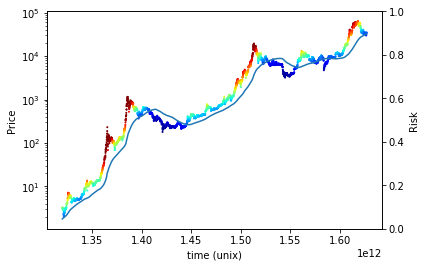

In [30]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
timestamps=fast['unix']
# ax1.plot(fast['unix'],fast['value'])

risk=risk_indicator(btc_price_data,slow)
print(risk.iloc[-1])
# ax1.plot(btc_price_data['unix'],btc_price_data['close'])
# ax1.plot(fast['unix'],fast['value'])
ax1.plot(slow['unix'],slow['value'])
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_ylabel('Risk')
filtered_price_data=btc_price_data[btc_price_data['unix']>=risk['unix'].min()]
# filtered_risk=risk.loc[risk['value']<0.15]
# ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
#ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

ax1.scatter(filtered_price_data['unix'],filtered_price_data['close'], s=1, c=risk['value'], cmap='jet')


In [24]:
xrp_daily=process_coincodex_csv('XRPUSD_1d.csv')
xrp_daily

,date,open,high,low,close,volume,market cap,unix
0,Aug-04-2013,0.005875,0.005980,0.005613,0.005613,0.000000e+00,4.529245e+07,1375545600000
1,Aug-05-2013,0.005637,0.005661,0.004629,0.004680,0.000000e+00,3.975495e+07,1375632000000
2,Aug-06-2013,0.004669,0.004682,0.004333,0.004417,0.000000e+00,3.486680e+07,1375718400000
3,Aug-07-2013,0.004397,0.004424,0.004175,0.004254,0.000000e+00,3.357288e+07,1375804800000
4,Aug-08-2013,0.004257,0.004367,0.004253,0.004291,0.000000e+00,3.355898e+07,1375891200000
...,...,...,...,...,...,...,...,...
2907,Jul-20-2021,0.529192,0.581656,0.521053,0.570157,2.719891e+09,2.550728e+10,1626710400000
2908,Jul-21-2021,0.571222,0.602090,0.562035,0.591995,3.331822e+09,2.679295e+10,1626796800000
2909,Jul-22-2021,0.592102,0.609048,0.577260,0.609048,2.704250e+09,2.736615e+10,1626883200000
2910,Jul-23-2021,0.609173,0.620159,0.601413,0.609553,2.441612e+09,2.804482e+10,1626969600000


In [26]:
xrp_weekly=price.get_price_data('1w',data=xrp_daily)
xrp_weekly

,unix,open,high,low,close
0,1376150400000,0.005637,0.005661,0.004175,0.004449
1,1376755200000,0.004463,0.006263,0.002875,0.005260
2,1377360000000,0.005376,0.006507,0.004919,0.006417
3,1377964800000,0.006468,0.006936,0.005507,0.005528
4,1378569600000,0.005518,0.006552,0.005405,0.006270
...,...,...,...,...,...
411,1624723200000,0.610924,0.688857,0.515182,0.644084
412,1625328000000,0.644358,0.725647,0.635268,0.657982
413,1625932800000,0.654274,0.679228,0.594739,0.631329
414,1626537600000,0.630230,0.638006,0.555637,0.560635


true


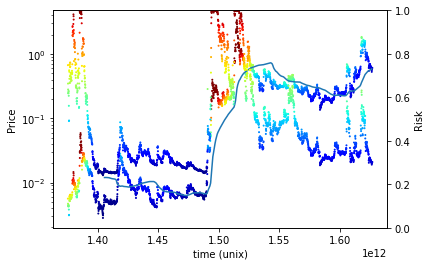

In [33]:
slow_xrp=get_sma(xrp_weekly,50)
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
timestamps=fast['unix']
# ax1.plot(fast['unix'],fast['value'])

risk_xrp=risk_indicator(xrp_daily,slow)
# ax1.plot(btc_price_data['unix'],btc_price_data['close'])
# ax1.plot(fast['unix'],fast['value'])
ax1.plot(slow_xrp['unix'],slow_xrp['value'])
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_ylabel('Risk')
xrp_price_data=xrp_daily[xrp_daily['unix']>=risk_xrp['unix'].min()]
# filtered_risk=risk.loc[risk['value']<0.15]
# ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
#ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

ax1.scatter(xrp_price_data['unix'],xrp_price_data['close'], s=1, c=risk_xrp['value'], cmap='jet')
ax2.scatter(risk_xrp['unix'],risk_xrp['value'], s=1, c=risk_xrp['value'], cmap='jet')
print(risk_xrp.iloc[-1])